In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
%matplotlib inline

# Zad 1.
Napisz algorytm z poniższej pracy w 2d:
* Przemysław Spurek *General split gaussian Cross–Entropy clustering* Expert Systems with Applications, 58–68, 68 (2017)
  * [Preprint](http://ww2.ii.uj.edu.pl/~spurek/publications/SGCEC.pdf)
  * [Article](http://www.sciencedirect.com/science/article/pii/S0957417416305565)
  
Zauważ, że wystarczy zmienić gęstość w poprzednim rozwiązaniu na Split Gaussian. 

Testowe zbiory danych:

[Zbiór 1](http://ww2.ii.uj.edu.pl/~spurek/AD_15_16/beg.txt)

[Zbiór 2](http://ww2.ii.uj.edu.pl/~spurek/AD_15_16/faithful.dat.txt)

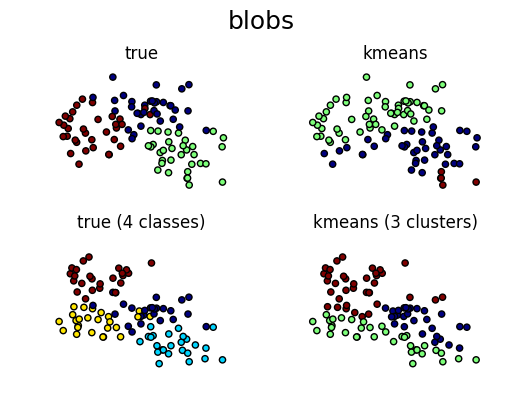

In [29]:
epsilon = np.nextafter(0, 1)
#epsilon = 0.00001
epsilon_2 = [np.nextafter(0, 1), np.nextafter(0, 1)]

@np.vectorize
def split_gauss_pdf(x, mu, sigma, tau):
    sigma = np.maximum(sigma, epsilon)
    tau = np.maximum(tau, epsilon)
    c =  1 / (sigma + tau)
    if x < mu:
        scale = sigma
    else:
        scale = tau
    return 2 * c * scale * norm.pdf(x, loc=mu, scale=scale)
        
def split_gauss_2d_pdf(x, y, m, W, sigma, tau):
    sigma = np.max(np.column_stack((sigma, epsilon_2)), axis=1)
    tau = np.max(np.column_stack((tau, epsilon_2)), axis=1)
    z = np.array([x - m[0], y - m[1]])
    ans = np.linalg.det(W) * split_gauss_pdf(np.dot(W[:, 0].T, z), 0, sigma[0], tau[0]) \
                    * split_gauss_pdf(np.dot(W[:, 1].T, z), 0, sigma[1], tau[1])
    #if np.any(np.isnan(ans)):
    #    ans = epsilon
    return np.maximum(ans, epsilon)

def loglike_split(X, m, W, sigma, tau):
    W = W.reshape(2, 2)
    return min(-epsilon, np.sum(np.log(split_gauss_2d_pdf(X[:, 0], X[:, 1], m, W, sigma, tau))))

def est_params(X):
    split_params = np.array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1], dtype='float64')
    mean = np.mean(X, axis=0)
    # mean = minimize(lambda p: (-1) * loglike_split(X, 
    #                                               p, 
    #                                               split_params[2:6],
    #                                               split_params[6:8],
    #                                               split_params[8:]), 
    #                                               split_params[:2]).x
    W = minimize(lambda p: (-1) * loglike_split(X, 
                                                  mean, 
                                                  p,
                                                  split_params[6:8],
                                                  split_params[8:]), 
                                                  split_params[2:6],
                                                  bounds=((-1, 1), (-1, 1), (-1, 1), (-1, 1))).x
    sigma = minimize(lambda p: (-1) * loglike_split(X, 
                                                  mean, 
                                                  W,
                                                  p,
                                                  split_params[8:]), 
                                                  split_params[6:8],
                                                  bounds=((0, None), (0, None))).x
    tau = minimize(lambda p: (-1) * loglike_split(X, 
                                                  mean, 
                                                  W,
                                                  sigma,
                                                  p), 
                                                  split_params[8:],
                                                  bounds=((0, None), (0, None))).x
    return mean, np.resize(W, (2, 2)), sigma, tau

class SGCEC(object):
    
    def __init__(self, eps):
        
        self.labels = None
        self.clusters = None
        self.n_clusters = None
        self.cluster_centers = None
        
        self.probs = None
        self.covs = None
        self.sigmas = None
        self.taus = None
        self.epsilon = eps
       

    def fit(self, X, n_clusters):
        
        X=X.astype('float64')
        
        def f(x, i):
            a = split_gauss_2d_pdf(x=x[0], 
                                   y=x[1],  
                                   m=self.cluster_centers[i],
                                   W=self.covs[i],
                                   sigma=self.sigmas[i],
                                   tau=self.taus[i]
                                  )
            b = self.probs[i]
            ans = - np.log(b) - np.log(a)
            #print("pdf " + str(a), "prob " + str(b), "ans " + str(ans))
            return ans
        
        n = X.shape[0]
        self.n_clusters = n_clusters
        
        h = float("inf")
        
        # initialize cluster centers randomly
        self.cluster_centers = X[np.random.choice(n, self.n_clusters, replace=False)]
        
        # initialize probabilities
        self.probs = np.repeat(1 / n_clusters, n_clusters)
        
        # initialize covs, sigmas, taus
        self.covs = np.array([[[1, 0], [0, 1]]] * n_clusters, dtype='float64')
        #print(self.covs.shape)
        #print(self.covs)
        self.sigmas = np.array([[1, 1]] * n_clusters, dtype='float64')
        #print(self.sigmas.shape)
        #print(self.sigmas)
        self.taus = np.array([[1, 1]] * n_clusters, dtype='float64')
        #print(self.taus.shape)
        #print(self.taus)
        
        # iterate until change in energy is smaller than epsilon
        iter = 0
        while(True):
            
            
            # assign points to clusters
            self.labels = []
            for i in range(n):
                #print("    pt numb " + str(i), list(map(lambda c: f(X[i], c), range(n_clusters))))
                self.labels.append(np.argmin(list(map(lambda c: f(X[i], c), range(n_clusters)))))
            self.clusters = np.array([np.array([x for x in range(n) if self.labels[x] == c]) for c in range(self.n_clusters)])
            
            #print("probs", self.probs, "cluster shapes", self.clusters[0].shape, self.clusters[1].shape, self.clusters[2].shape)
            
            # delete small clusters
            
            # compute new probabilities
            self.probs = list(map(lambda c: self.clusters[c].shape[0] / n, range(self.n_clusters)))
            #print("probs", self.probs)
            
            # compute new cluster centers
            #self.cluster_centers = np.array(list(map(lambda c: np.mean(X[c], axis=0), self.clusters)))
            
            # compute new means, covs, sigmas and taus
            for c in range(n_clusters):
                #print("cluster nb " + str(c), self.clusters[c])
                a = est_params(X[self.clusters[c]])
                #print(a[0], a[1], a[2], a[3])
                self.cluster_centers[c], self.covs[c], self.sigmas[c], self.taus[c] = est_params(X[self.clusters[c]])
    
            #self.covs = list(map(lambda c: np.cov(X[self.clusters[c]], rowvar=False), range(self.n_clusters)))
            
            # compute h_new
            g = lambda c: self.probs[c] * (-np.log(self.probs[c]) - 
                                 np.mean(np.log(split_gauss_2d_pdf(X[self.clusters[c]][0], 
                                                                   X[self.clusters[c]][1],
                                                                   self.cluster_centers[c],
                                                                   self.covs[c],
                                                                   self.sigmas[c],
                                                                   self.taus[c]
                                                                  ))))
            h_new = np.sum(list(map(g, range(n_clusters))))
            
            # end if change in energy is smaller than epsilon
            if np.abs(h_new - h) < self.epsilon:
                break
            iter += 1
            if iter > 5:
                break
            
            h = h_new
        
        return self

eps = 0.01
    
from sklearn.datasets.samples_generator import make_blobs
X_blobs, y_blobs = make_blobs(n_samples=100, centers=3, n_features=2, random_state=0)
n_classes = len(set(y_blobs))
m = SGCEC(eps).fit(X_blobs, n_classes)

plt.suptitle("blobs" , fontsize=18, verticalalignment='bottom')

plt.subplot(221)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs)
plt.axis('off')
plt.title("true")

plt.subplot(222)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=m.labels)
plt.axis('off')
_ = plt.title("sgcec")

X_blobs, y_blobs = make_blobs(n_samples=100, centers=4, n_features=2, random_state=0)
m = SGCEC(eps).fit(X_blobs, 3)

plt.subplot(223)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs)
plt.axis('off')
plt.title("true (4 classes)")

plt.subplot(224)
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=m.labels)
plt.axis('off')
_ = plt.title("sgcec (3 clusters)")

C:\Program Files\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1645: RuntimeWarning: overflow encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


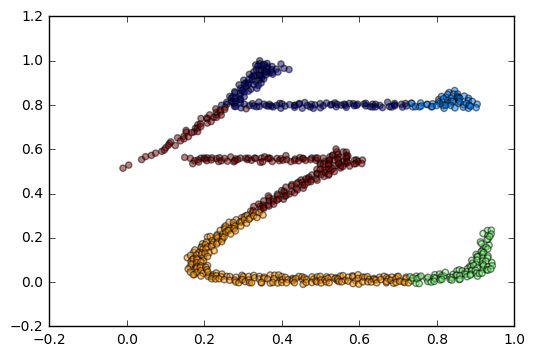

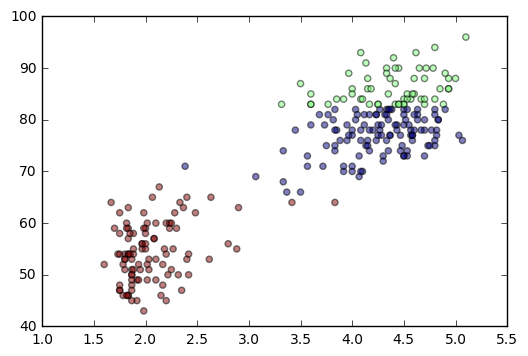

In [31]:
data_1 = pd.read_csv(r"files/beg.txt", delimiter=" ", header=None)
data_2 = pd.read_csv(r"files/faithful.dat.txt", delimiter=" ", header=None)

beg = np.array(data_1)
faithful = np.array(data_2)

m = SGCEC(0.0001).fit(beg, 5)
plt.scatter(beg[:, 0], beg[:, 1], c=m.labels, alpha=0.5)
plt.show()

m = SGCEC(0.0001).fit(faithful, 3)
plt.scatter(faithful[:, 0], faithful[:, 1], c=m.labels, alpha=0.5)
plt.show()